In [ ]:
!git clone https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0.git
!mv ./StyleGAN2-Tensorflow-2.0/* .
!rm -r StyleGAN2-Tensorflow-2.0

Cloning into 'StyleGAN2-Tensorflow-2.0'...
remote: Enumerating objects: 58, done.
remote: Total 58 (delta 0), reused 0 (delta 0), pack-reused 58
Unpacking objects: 100% (58/58), done.


In [ ]:
!mkdir Models
!mkdir Results
!mkdir data
!mkdir vectors
!rm -r sample_data

mkdir: cannot create directory ‘Models’: File exists
mkdir: cannot create directory ‘Results’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘vectors’: File exists
rm: cannot remove 'sample_data': No such file or directory


In [ ]:
!gdown --id 1GOjghy2kKLC3EfLhTF2BntYPoPjXgUGn
!unzip LandscapesBig.zip -d Models/
!rm LandscapesBig.zip

Downloading...
From: https://drive.google.com/uc?id=1GOjghy2kKLC3EfLhTF2BntYPoPjXgUGn
To: /content/LandscapesBig.zip
156MB [00:01, 133MB/s]
Archive:  LandscapesBig.zip
replace Models/dis.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Models/dis_28.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!pip install tensorflow==2.0
!pip install tensorflow-gpu==2.0

In [ ]:
from stylegan_two import StyleGAN, noiseList, nImage, noise
import numpy as np

model = StyleGAN()
model.load(28)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1536)         3072        lambda[0][0]                     
__________________________________________________________________________________________________
reshape (Reshape)               (None, 4, 4, 96)     0           dense_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
import numpy as np
from PIL import Image

def generate_image_from_style(style,n2):
  #n2 = nImage(1)
  n2 = n2
  n_list = [style] * 7
  test = model.generateTruncated(style= n_list, noi = n2, trunc = 1)
  test = np.concatenate(test, axis = 0)
  c1 = np.clip(test, 0.0, 1.0)
  x = Image.fromarray(np.uint8(c1*255))
  return x

def img_from_latent_arr(inp_file,comb):
  n2 = nImage(1)
  single_latent = np.zeros((1,512))
  for i in range(len(inp_file)):
    latent = np.load('vectors/' + inp_file[i]).reshape((1, 512))
    single_latent += latent * comb[i]
  x = generate_image_from_style(single_latent)
  return x

In [ ]:
rows = 45000
latent_space = noise(rows)
arr = model.GAN.S.predict(latent_space, batch_size = 64)
print(arr.shape)

(45000, 512)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(arr)
arr_pca = pca.transform(arr)
print("variance ratio: ", pca.explained_variance_ratio_)
print("sum ", sum(pca.explained_variance_ratio_))
print(pca.components_.shape)

variance ratio:  [2.55387306e-01 2.04637289e-01 1.48429543e-01 1.08770445e-01
 7.41659477e-02 4.22457829e-02 1.54778529e-02 1.45056853e-02
 1.32976286e-02 1.17098847e-02 9.12098121e-03 8.71068519e-03
 7.12365657e-03 6.14914810e-03 5.63572347e-03 5.10697300e-03
 4.47816262e-03 4.08024574e-03 3.85655952e-03 3.47549422e-03
 3.24882148e-03 2.88610440e-03 2.11997190e-03 1.91061024e-03
 1.74895208e-03 1.59751461e-03 1.41945027e-03 1.22307194e-03
 1.14184525e-03 9.88347572e-04 9.40022757e-04 8.24232644e-04
 7.71922525e-04 7.44273595e-04 6.81016943e-04 6.52241928e-04
 6.28888723e-04 6.15911325e-04 5.67965209e-04 5.34948253e-04
 5.04396448e-04 4.92417952e-04 4.88529739e-04 4.68128012e-04
 4.38750460e-04 4.24943370e-04 4.06148669e-04 4.03860060e-04
 3.90691392e-04 3.70753347e-04 3.67850502e-04 3.56759847e-04
 3.40853119e-04 3.29997798e-04 3.18791863e-04 3.09473311e-04
 2.99251231e-04 2.87366129e-04 2.86127965e-04 2.83739530e-04
 2.75864819e-04 2.69085926e-04 2.66011630e-04 2.57965847e-04
 2.5682

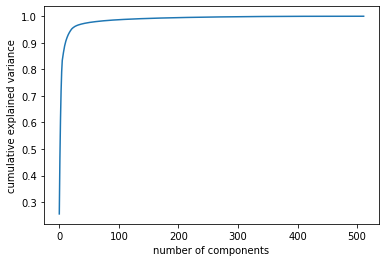

In [ ]:
import matplotlib.pyplot as plt
pca = PCA(whiten=True).fit(arr)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
projection = arr@pca.components_.T
scaled_pca =(pca.components_.T * (np.linalg.norm(projection, axis = 0)/np.sqrt(rows))).T




In [ ]:
from scipy import spatial

pc_count = 10

tree = spatial.KDTree(arr)
index = tree.query(scaled_pca[:pc_count])[1]
index = np.unique(index)

In [ ]:
def generate_from_w(self, style, w_vector, w_list, noi = np.zeros([44]), trunc = 0.5):
        #Wlist => katsayılar, w_vector => vectör'ün kendisi
        #Get W's center of mass
        if self.av.shape[0] == 44: #44 is an arbitrary value
            print("Approximating W center of mass")
            self.av = np.mean(self.GAN.S.predict(noise(2000), batch_size = 64), axis = 0)
            self.av = np.expand_dims(self.av, axis = 0)

        if noi.shape[0] == 44:
            noi = nImage(64)

        w_space = []
        for i in range(len(style)):
            tempStyle = self.GAN.S.predict(style[i])
            tempStyle += w_list[i] * w_vector
            #tempStyle = trunc * (tempStyle - self.av) + self.av
            w_space.append(tempStyle)

        generated_images = self.GAN.GE.predict(w_space + [noi], batch_size = 16)
        generated_images = np.concatenate(generated_images, axis = 0)
        c1 = np.clip(generated_images, 0.0, 1.0)
        x = Image.fromarray(np.uint8(c1*255))


        return x

Approximating W center of mass


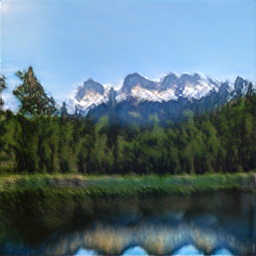

In [ ]:
base = noise(1)
n2 = nImage(1)
generate_image_from_style(base,n2)

In [ ]:
def generate_from_w2(self, style, noi = np.zeros([44]), trunc = 0.5):
        #Wlist => katsayılar, w_vector => vectör'ün kendisi
        #Get W's center of mass
        # if self.av.shape[0] == 44: #44 is an arbitrary value
        #     print("Approximating W center of mass")
        #     self.av = np.mean(self.GAN.S.predict(noise(2000), batch_size = 64), axis = 0)
        #     self.av = np.expand_dims(self.av, axis = 0)
        n_list = [style] * 7
        if noi.shape[0] == 44:
            noi = nImage(64)

        # w_space = []
        # for i in range(len(w_vector)):
        #     tempStyle = self.GAN.S.predict(style[i])
        #     tempStyle += w_list[i] * scaled_pca[i]
        #     #tempStyle = trunc * (tempStyle - self.av) + self.av
        #     w_space.append(tempStyle)

        generated_images = self.GAN.GE.predict(n_list + [noi], batch_size = 16)
        generated_images = np.concatenate(generated_images, axis = 0)
        c1 = np.clip(generated_images, 0.0, 1.0)
        x = Image.fromarray(np.uint8(c1*255))


        return x

In [ ]:
"""w_vec = scaled_pca[:7]
scale = [-2]
w_list = scale * 7
generate_from_w2(self = model, style = [base] * 7, w_vector = w_vec,
                w_list = w_list, noi = n2, trunc = 1)"""

'w_vec = scaled_pca[:7]\nscale = [-2]\nw_list = scale * 7\ngenerate_from_w2(self = model, style = [base] * 7, w_vector = w_vec,\n                w_list = w_list, noi = n2, trunc = 1)'

In [ ]:
"""base = noise(1)
generate_image_from_style(base)"""

'base = noise(1)\ngenerate_image_from_style(base)'

# Widget APP

Get Latent directions

In [ ]:
from pathlib import Path
def get_control_latent_vectors():
    #files = [x for x in Path('vectors').iterdir() if str(x).endswith('.npy')]
    #latent_vectors = {f.name[:-4]:np.load(f) for f in files}
    latent_vectors = {"PCA " + str(i):scaled_pca[i] for i in range(pc_count)}
    return latent_vectors

In [ ]:
latent_controls = get_control_latent_vectors()
#len(latent_controls), latent_controls.keys()
print(len(latent_controls['PCA 2']))

512


Create Sample image and return the image and its vector

In [ ]:
def img_from_latent():
  n2 = nImage(1)
  n_list = noiseList(1)
  test = model.generateTruncated(style= n_list, noi = n2, trunc = 1)
  test = np.concatenate(test, axis = 0)
  c1 = np.clip(test, 0.0, 1.0)
  x = Image.fromarray(np.uint8(c1*255))
  vector = model.GAN.S.predict(n_list[0])
  return x,vector

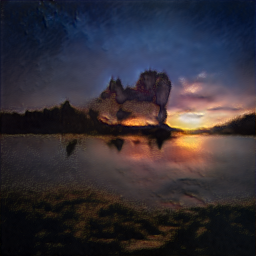

In [ ]:
np.random.seed(15)
image_to_use,latent_code_to_use = img_from_latent()
image_to_use

Codes For the Widget App

In [ ]:
import IPython
import ipywidgets as widgets

def generate_image_from_style(style):
  n2 = nImage(1)
  n_list = [style] * 7
  test = model.generateTruncated(style= n_list, noi = n2, trunc = 1)
  test = np.concatenate(test, axis = 0)
  c1 = np.clip(test, 0.0, 1.0)
  x = Image.fromarray(np.uint8(c1*255))
  return x


def apply_latent_controls(self):
    
    image_outputs = controller.children[0]
    feature_sliders = controller.children[1]
    
    slider_hboxes = feature_sliders.children[:-2]
    latent_movements = [(x.children[1].value, x.children[0].value) for x in slider_hboxes]

    modified_latent_code = np.array(latent_code_to_use)
    w_vec = []
    w_vec = np.array(w_vec)
    style = np.zeros(512)
    #style = [modified_latent_code] * 7
    for feature, amount_to_move in latent_movements:      
        modified_latent_code += latent_controls[feature] * amount_to_move
    #   w_vec = np.append(w_vec,amount_to_move)
    #   print(latent_controls[feature])
    #   print(amount_to_move)
    # print(w_vec)
    #print(latent_controls[feature])
    latent_img = generate_from_w2(model, modified_latent_code, noi = n2)
    
    latent_img_output = image_outputs.children[1]
    with latent_img_output:
        latent_img_output.clear_output()
        display(latent_img)

def reset_latent_controls(self):
    
    image_outputs = controller.children[0]
    feature_sliders = controller.children[1]
    
    slider_hboxes = feature_sliders.children[:-2]
    for x in slider_hboxes:
        x.children[0].value = 0
        
    latent_img_output = image_outputs.children[1]
    with latent_img_output:
        latent_img_output.clear_output()
        display(image_to_use)

def create_interactive_latent_controller():
    orig_img_output = widgets.Output()

    with orig_img_output:
        orig_img_output.clear_output()
        display(image_to_use)

    latent_img_output = widgets.Output()

    with latent_img_output:
        latent_img_output.clear_output()
        display(image_to_use)

    image_outputs = widgets.VBox([orig_img_output, latent_img_output])

    #collapse-hide
    generate_button = widgets.Button(description='Generate', layout=widgets.Layout(width='75%', height='10%'))
    generate_button.on_click(apply_latent_controls)

    reset_button = widgets.Button(description='Reset Latent Controls', layout=widgets.Layout(width='75%', height='10%'))
    reset_button.on_click(reset_latent_controls)

    feature_sliders = []
    for feature in latent_controls:
        label = widgets.Label(feature)
        slider = widgets.FloatSlider(min=-5, max=5)
        feature_sliders.append(widgets.HBox([slider, label]))
    feature_sliders.append(generate_button)
    feature_sliders.append(reset_button)
    feature_sliders = widgets.VBox(feature_sliders)

    return widgets.HBox([image_outputs, feature_sliders])

In [ ]:
np.random.seed(1423)
n2 = nImage(1)
image_to_use,latent_code_to_use = img_from_latent()
#image_to_use
#print(latent_code_to_use)
controller = create_interactive_latent_controller()
controller

In [ ]:
def images_horizontally(imgs):
  imgs_comb = np.hstack( (np.asarray(i) for i in imgs ) )
  # save that beautiful picture
  imgs_comb = Image.fromarray(imgs_comb)
  return imgs_comb

def images_vertically(imgs):
  imgs_comb = np.vstack( (np.asarray(i) for i in imgs ) )
  # save that beautiful picture
  imgs_comb = Image.fromarray(imgs_comb)
  return imgs_comb

[-2.         -1.33333333 -0.66666667  0.          0.66666667  1.33333333
  2.        ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


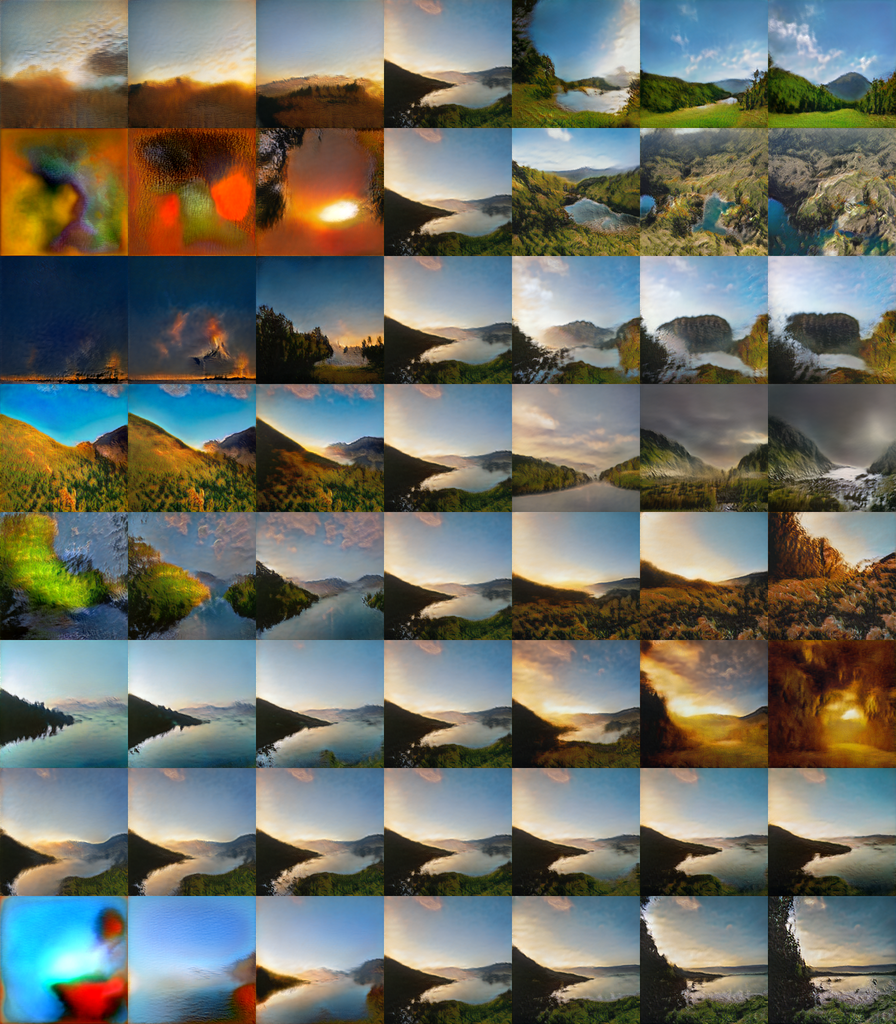

In [ ]:
from PIL import ImageDraw, ImageFont
#np.random.seed(1367)
# -1.50<ground < 1.50
# -1.40< plant < 2.00
# -3.00< sky < 3.00
# -1.00< solid < 2.00
# -5.00< tepe < 5.00
# 0< snow < 2.00

np.random.seed(1423)
n2 = nImage(1)

image_to_use,latent_code_to_use = img_from_latent()

num_pics = 7
movements = np.linspace(-2, 2, num_pics)
print(movements)
spaces = [movements] * 8



img_v = []
for i in range(8):
  img_h = []
  movements = spaces[i]
  for j in movements:
    modified_latent_code = latent_code_to_use + j * scaled_pca[i]
    img_h.append(generate_from_w2(model, modified_latent_code, noi = n2))
  
  img_v.append(images_horizontally(img_h))


img = images_vertically(img_v)
w, h = img.size
img = img.resize((w//2, h//2), Image.ANTIALIAS)
img